In [2]:
import pandas as pd
from pulp import *
import matplotlib.pyplot as plt


In [3]:
df = pd.read_excel("Supply chain logisitcs problem.xlsx")
df.head()


,Order ID,Order Date,Origin Port,Carrier,TPT,Service Level,Ship ahead day count,Ship Late Day count,Customer,Product ID,Plant Code,Destination Port,Unit quantity,Weight
0,1.447296e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,808,14.30
1,1.447158e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,3188,87.94
2,1.447139e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2331,61.20
3,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,847,16.16
4,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2163,52.34


In [5]:
data = df[['Plant Code', 'Destination Port', 'Unit quantity', 'Weight']]
data.head()


,Plant Code,Destination Port,Unit quantity,Weight
0,PLANT16,PORT09,808,14.30
1,PLANT16,PORT09,3188,87.94
2,PLANT16,PORT09,2331,61.20
3,PLANT16,PORT09,847,16.16
4,PLANT16,PORT09,2163,52.34


In [6]:
supply = data.groupby('Plant Code')['Unit quantity'].sum().to_dict()
supply


{'PLANT03': 28611617,
 'PLANT04': 348,
 'PLANT08': 277008,
 'PLANT09': 223830,
 'PLANT12': 112000,
 'PLANT13': 43379,
 'PLANT16': 245133}

In [7]:
demand = data.groupby('Destination Port')['Unit quantity'].sum().to_dict()
demand


{'PORT09': 29513315}

In [8]:
cost_df = data.groupby(['Plant Code', 'Destination Port'])['Weight'].mean().reset_index()

cost_matrix = {}
for _, row in cost_df.iterrows():
    cost_matrix[(row['Plant Code'], row['Destination Port'])] = row['Weight']

cost_matrix


{('PLANT03', 'PORT09'): 15.86307359365151,
 ('PLANT04', 'PORT09'): 2.1011073223608046,
 ('PLANT08', 'PORT09'): 14.49792128391422,
 ('PLANT09', 'PORT09'): 33.86371237813909,
 ('PLANT12', 'PORT09'): 27.15809960771134,
 ('PLANT13', 'PORT09'): 63.12085509882605,
 ('PLANT16', 'PORT09'): 185.94226539437193}

In [9]:
model = LpProblem("Supply_Chain_Optimization", LpMinimize)

plants = list(supply.keys())
ports = list(demand.keys())

x = LpVariable.dicts("ship",
                     [(p, d) for p in plants for d in ports],
                     lowBound=0)


In [10]:
model += lpSum(
    cost_matrix.get((p, d), 0) * x[(p, d)]
    for p in plants for d in ports
)


In [11]:
for p in plants:
    model += lpSum(x[(p, d)] for d in ports) <= supply[p]


In [12]:
for d in ports:
    model += lpSum(x[(p, d)] for p in plants) >= demand[d]


In [13]:
model.solve()
print("Status:", LpStatus[model.status])


Status: Optimal


In [14]:
result = []

for (p, d), var in x.items():
    if var.varValue is not None and var.varValue > 0:
        result.append([p, d, var.varValue])

result_df = pd.DataFrame(result, columns=['Plant', 'Port', 'Quantity'])
result_df.head()


,Plant,Port,Quantity
0,PLANT03,PORT09,28611617.0
1,PLANT04,PORT09,348.0
2,PLANT08,PORT09,277008.0
3,PLANT09,PORT09,223830.0
4,PLANT12,PORT09,112000.0


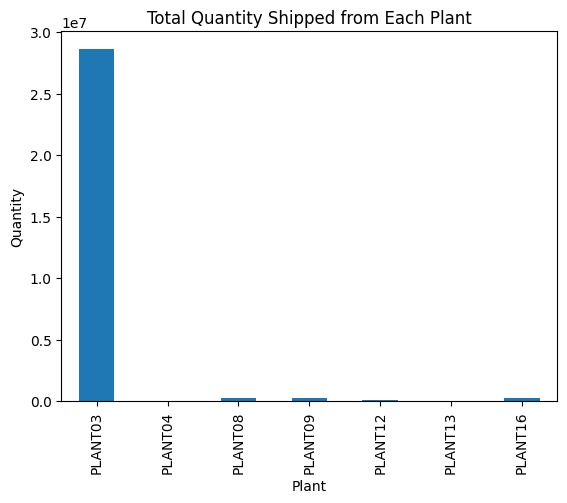

In [15]:
plant_summary = result_df.groupby('Plant')['Quantity'].sum()

plt.figure()
plant_summary.plot(kind='bar')
plt.title("Total Quantity Shipped from Each Plant")
plt.xlabel("Plant")
plt.ylabel("Quantity")
plt.show()


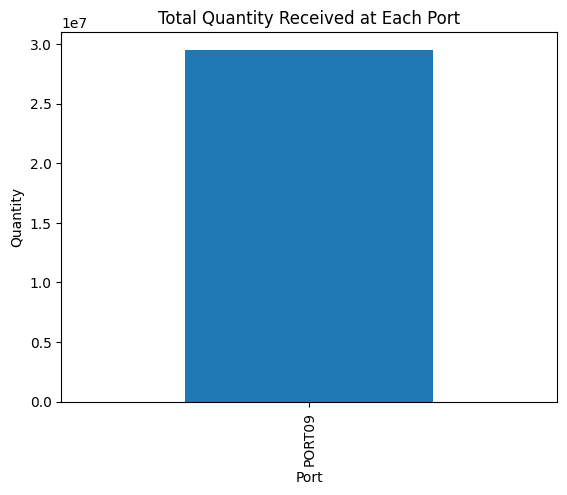

In [16]:
port_summary = result_df.groupby('Port')['Quantity'].sum()

plt.figure()
port_summary.plot(kind='bar')
plt.title("Total Quantity Received at Each Port")
plt.xlabel("Port")
plt.ylabel("Quantity")
plt.show()


<Figure size 640x480 with 0 Axes>

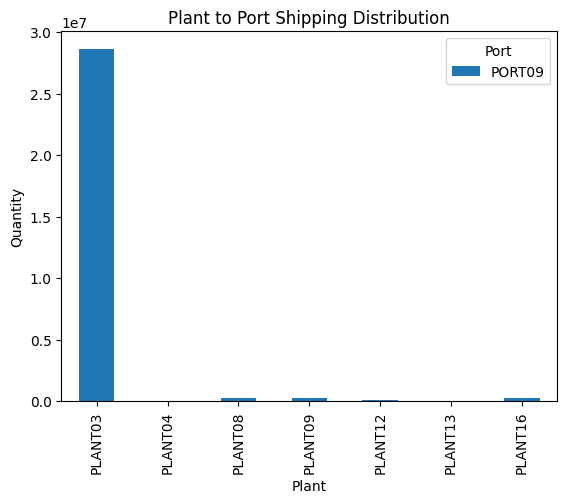

In [17]:
pivot = result_df.pivot(index='Plant', columns='Port', values='Quantity').fillna(0)

plt.figure()
pivot.plot(kind='bar', stacked=True)
plt.title("Plant to Port Shipping Distribution")
plt.xlabel("Plant")
plt.ylabel("Quantity")
plt.show()
